In [11]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%reload_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
%matplotlib inline

import gc
gc.enable()
base_dir = './data/'
from functions import utils
from pathlib import Path
from functions.prepare import (prepare_bureau, prepare_previous_application, raw_installments_payments,
                               prepare_train_test, one_hot_encoder,raw_previous_application,
                               prepare_pos_cash, prepare_installments_payments,raw_train_test,
                              prepare_credit_card_balance, timer)

from functions.cv_lgbm import train_model_LGBM

base_dir = Path(base_dir)

In [2]:
utils.cols_desc('DAYS_TERMINATION')

previous_application - Relative to application date of current application when was the expected termination of the previous application


In [3]:
application_train, application_test, y, categorical_feats = prepare_train_test(base_dir, 
                                                                               encode_categories='OHE')
unique_curr = set(application_test.SK_ID_CURR) | set(application_train.SK_ID_CURR)
application_train.set_index('SK_ID_CURR', inplace = True)
application_test.set_index('SK_ID_CURR', inplace = True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Initial test 
(48744, 121) 121
Initial train 
(307511, 122) 122
Final test 
(48744, 265) 265
Final train 
(307511, 265) 265


In [12]:
data , y  = raw_train_test(base_dir)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Initial test 
(48744, 121) 121
Initial train 
(307511, 122) 122


In [15]:
len(unique_curr)- len(set(previous_application.SK_ID_CURR))

17653

In [18]:
first_app = (unique_curr - set(previous_application.SK_ID_CURR))

In [6]:
previous_application = raw_previous_application(base_dir, unique_curr)
ins = raw_installments_payments(base_dir,unique_curr)

(1670214, 37)
remove Canceled, it seems that there is always a new application after those canceled
(1353895, 37)
Only in test/train set
Only in test/train set,  (1353895, 37)


In [44]:
utils.cols_desc('RATE_DOWN_PAYMENT')

previous_application - Down payment rate normalized on previous credit


In [8]:
ins_prec = ins.merge(previous_application, on=['SK_ID_PREV','SK_ID_CURR'], how='inner')

In [ ]:
12330713

In [47]:
ins_prec.PRODUCT_COMBINATION.value_counts(dropna=  False)

POS household with interest       2101732
Card X-Sell                       1621134
Card Street                       1373377
Cash X-Sell: middle               1365498
POS mobile with interest          1350618
Cash X-Sell: low                   947398
POS household without interest     942675
                                   ...   
Cash Street: high                  469798
Cash Street: middle                284569
Cash Street: low                   169323
POS other with interest            168400
POS mobile without interest        121363
POS industry without interest      105312
POS others without interest         17847
Name: PRODUCT_COMBINATION, Length: 16, dtype: int64

In [25]:
set(ins.SK_ID_PREV).__len__(), len(set(previous_application.SK_ID_PREV))

(997752, 1353895)

In [41]:
drop_cols = ['CODE_REJECT_REASON','FLAG_LAST_APPL_PER_CONTRACT']

In [48]:
ins_prec[ins_prec.RATE_INTEREST_PRIMARY.isna()]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
1,1054186,161674,1.0,2,-1300.0,-1307.0,6948.360,6948.360,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
2,1054186,161674,1.0,8,-1120.0,-1175.0,6948.360,6948.360,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
3,1054186,161674,1.0,12,-1000.0,-1033.0,6935.220,6935.220,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
4,1054186,161674,1.0,3,-1270.0,-1275.0,6948.360,6948.360,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
5,1054186,161674,1.0,1,-1330.0,-1338.0,6948.360,6948.360,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
6,1054186,161674,1.0,10,-1060.0,-1125.0,6948.360,6948.360,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12354568,2090546,438373,4.0,1,-13.0,NaN,35246.880,NaN,Consumer loans,35246.880,193500.0,193500.0,0.0,193500.0,WEDNESDAY,15,True,1,0.000000,NaN,NaN,NaN,Approved,-43,Cash through the bank,NaN,"Spouse, partner",Refreshed,Clothing and Accessories,POS,NaN,Stone,30,Clothing,6.0,low_normal,POS industry with interest,NaN,-13.0,137.0,NaN,NaN,0.0
12354569,2682640,418699,3.0,1,-24.0,NaN,42419.205,NaN,Consumer loans,4720.590,41562.0,41562.0,0.0,41562.0,WEDNESDAY,15,True,1,0.000000,NaN,NaN,NaN,Approved,-57,Cash through the bank,NaN,NaN,Repeater,Mobile,POS,NaN,Country-wide,25,Connectivi

In [66]:
def main():
    application_train, application_test, y, categorical_feats = prepare_train_test(base_dir, 
                                                                                   encode_categories='OHE')
    unique_curr = set(application_test.SK_ID_CURR) | set(application_train.SK_ID_CURR)
    application_train.set_index('SK_ID_CURR', inplace = True)
    application_test.set_index('SK_ID_CURR', inplace = True)
    
    with timer("Process bureau and bureau_balance"):
        bureau = prepare_bureau(base_dir)
        print("Bureau bureau shape:", bureau.shape)
        application_train = application_train.join(bureau, how='left')
        application_test = application_test.join(bureau, how='left')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        previous_application = prepare_previous_application(base_dir, unique_curr)
        print("Previous applications df shape:", previous_application.shape)
        application_train = application_train.join(previous_application, how='left')
        application_test = application_test.join(previous_application, how='left')
        del previous_application
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = prepare_pos_cash(base_dir)
        print("Pos-cash balance df shape:", pos.shape)
        application_train = application_train.join(pos, how='left')
        application_test = application_test.join(pos, how='left')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        installments = prepare_installments_payments(base_dir, unique_curr)
        print("Installments payments df shape:", installments.shape)
        application_train = application_train.join(installments, how='left')
        application_test = application_test.join(installments, how='left')
        del installments
        gc.collect()
    with timer("Process credit card balance"):
        credit_card = prepare_credit_card_balance(base_dir)
        print("Credit card balance df shape:", credit_card.shape)
        application_train = application_train.join(credit_card, how='left')
        application_test = application_test.join(credit_card, how='left')
        del credit_card
        gc.collect()
    return application_train.reset_index(), application_test.reset_index(), y
    


with timer("Full model run"):
    application_train, application_test, y = main()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


Initial test 
(48744, 121) 121
Initial train 
(307511, 122) 122
Final test 
(48744, 265) 265
Final train 
(307511, 265) 265
bureau_balance shape :  (27299925, 11) - unique 817395
Bureau bureau shape: (305811, 95)
Process bureau and bureau_balance - done in 25s
(1670214, 37)
remove Canceled, it seems that there is always a new application after those canceled
(1353895, 37)
Only in test/train set
Only in test/train set,  (1353895, 37)
Final, 
(338602, 203) 203
Previous applications df shape: (338602, 203)
Process previous_applications - done in 18s
pos_cash shape :  (10001358, 8)
pos_cash shape :  (337252, 19)
Pos-cash balance df shape: (337252, 19)
Process POS-CASH balance - done in 14s
installments shape :  (339587, 36)
Installments payments df shape: (339587, 36)
Process installments payments - done in 37s
credit card shape :  (103558, 113)
Credit card balance df shape: (103558, 113)
Process credit card balance - done in 17s
Full model run - done in 121s


In [3]:
application_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_DOC_IND_KURT,NEW_LIVE_IND_SUM,NEW_INC_PER_CHLD,NEW_INC_BY_ORG,NEW_EMPLOY_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_SOURCES_PROD,NEW_EXT_SOURCES_MEAN,NEW_SCORES_STD,NEW_CAR_TO_BIRTH_RATIO,NEW_CAR_TO_EMPLOY_RATIO,NEW_PHONE_TO_BIRTH_RATIO,NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER,NEW_CREDIT_TO_INCOME_RATIO,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/

In [115]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
oof_preds, df_oof_preds, test_preds, importances, score = train_model_LGBM(application_train, 
                                                                           y['TARGET'], application_test,
                                                                           folds , 
                                                                           ignore_cols_=['SK_ID_CURR'])

In [41]:
# Save test predictions
base_name = '5x-LGB-run-01-only_application'

now = datetime.now()
score = str(round(score, 6)).replace('.', '')
sub_file = f'subs/submission_{base_name}_' + score + '_' + str(now.strftime('%Y-%m-%d-%H-%M')) + '.csv.gz'
test_preds.to_csv(sub_file, index=False, compression  = 'gzip' )
oof_file = f'subs/train_{base_name}-oof_' + score + '_' + str(now.strftime('%Y-%m-%d-%H-%M')) + '.csv.gz'
df_oof_preds.to_csv(oof_file, index=False, compression  = 'gzip')
# Display a few graphs

In [117]:
folds_idx = [(trn_idx, val_idx)
             for trn_idx, val_idx in folds.split(application_train, y['TARGET'])]

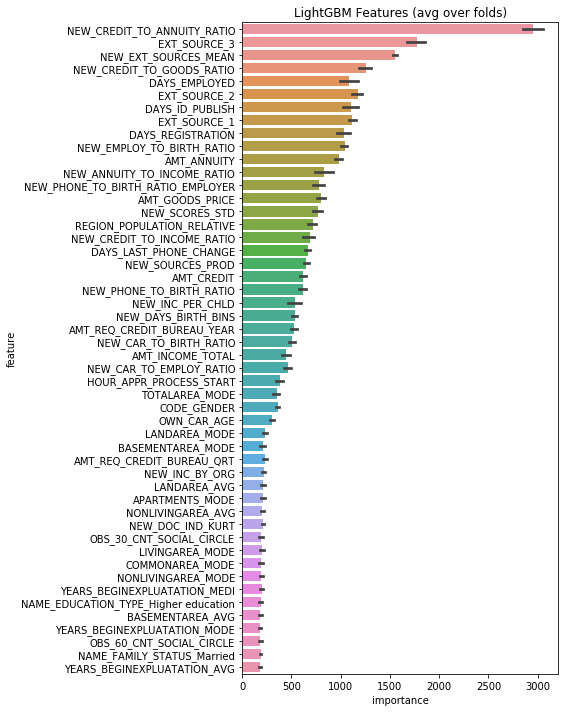

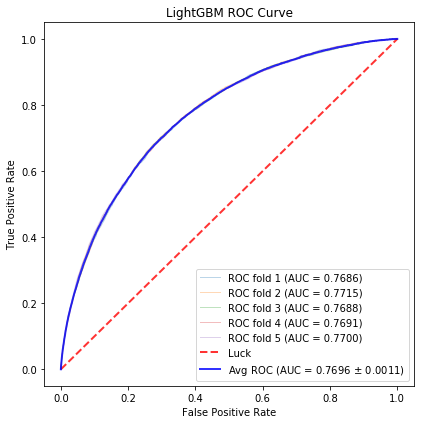

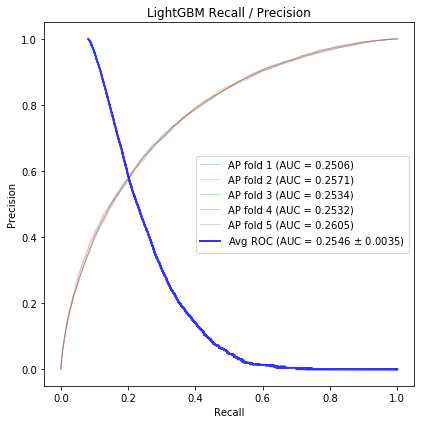

In [118]:
utils.display_importances(feature_importance_df_=importances)
utils.display_roc_curve(y_=y['TARGET'], oof_preds_=oof_preds, folds_idx_=folds_idx)
utils.display_precision_recall(y_=y['TARGET'], oof_preds_=oof_preds, folds_idx_=folds_idx)

In [44]:
!!kaggle competitions submit -c home-credit-default-risk -f {sub_file} -m "LGBM 750 features cv5"

['Successfully submitted to Home Credit Default Risk']

In [17]:
from functions.feature_selector import FeatureSelector

In [18]:
fs = FeatureSelector(data = application_train, labels = y['TARGET'])

In [19]:
fs.identify_missing(missing_threshold=0.6)

177 features with greater than 0.60 missing values.



In [21]:
missing_featuresmissing  = fs.ops['missing']